In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    GlobalMaxPooling2D,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob as gb
import cv2
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.applications import resnet

In [2]:
shape = (224, 224, 3)
image_size = 224
train_path = "./Brain Tumor/Training/"
test_path = "./Brain Tumor/Testing/"

In [3]:
def read_images_from_directory(
    folder_path,
    desc,
):
    """
    Analyzes the sizes of JPEG images within each subfolder of the given directory.

    Parameters:
    - train_path: str. The path to the directory containing subfolders of images.
    - desc: str. A description for the tqdm progress bar.

    Returns:
    - A pandas Series object with the counts of each unique image size.
    """
    images = []
    labels = []

    # Iterate through each folder in the given directory with a progress bar

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + "/" + folder + "/*.jpg"))

        # For each file in the current folder, read the image and append its size
        for file in tqdm(files, desc=desc + " in " + folder):
            image = plt.imread(file)
            img_resized = cv2.resize(image, (image_size, image_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img_rgb)
            labels.append(folder)

    # Count the occurrence of each unique size
    return images, labels

In [4]:
x_train, y_train = read_images_from_directory(train_path, "Loading Training Data")

Loading Training Data in pituitary_tumor: 100%|██████████| 827/827 [00:07<00:00, 111.47it/s]


In [5]:
x_test, y_test = read_images_from_directory(test_path, "Loading Testing Data")

Loading Testing Data in pituitary_tumor: 100%|██████████| 74/74 [00:01<00:00, 54.53it/s]


In [6]:
def visualize_data(list_of_images, labels):
    plt.figure(figsize=(20, 20))
    for n, i in enumerate(list(np.random.randint(0, len(list_of_images), 36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        plt.title(labels[i])

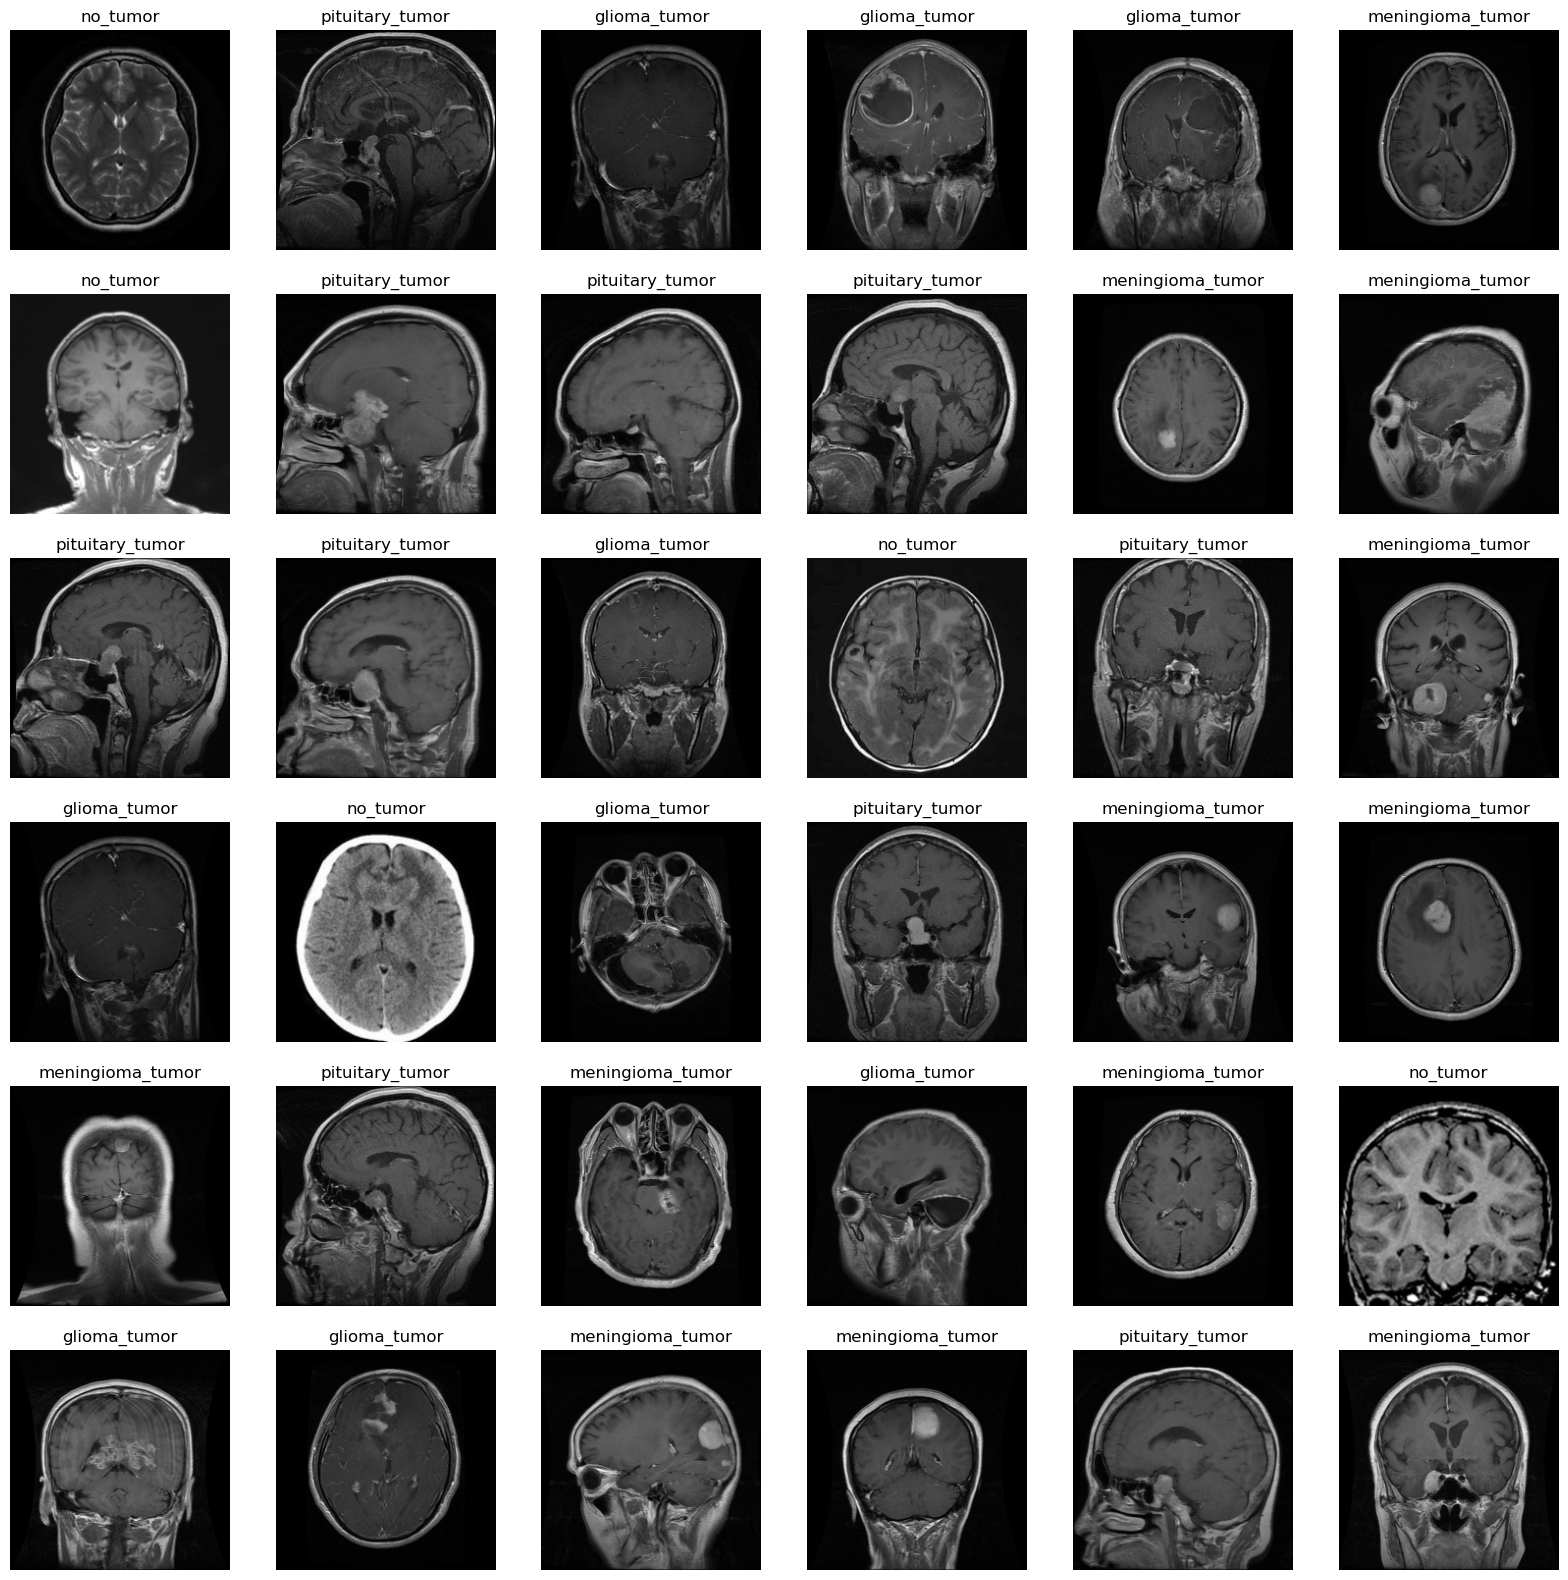

In [7]:
visualize_data(x_train, y_train)

In [8]:
def visualize_class_distribution(y_train, y_test):
    """
    Visualizes the class distribution in training and testing datasets when the labels are provided as lists.
    Adds a numeric label at the top of each bar showing the count.

    Parameters:
    - y_train: List of training labels.
    - y_test: List of testing labels.
    """
    train_counter = Counter(y_train)
    test_counter = Counter(y_test)

    all_labels = list(set(train_counter.keys()).union(set(test_counter.keys())))
    all_labels.sort()  # Sort the labels for consistent plotting
    train_counts = [train_counter[label] for label in all_labels]
    test_counts = [test_counter[label] for label in all_labels]

    x = range(len(all_labels))  # Label locations

    fig, ax = plt.subplots()
    train_bars = ax.bar(
        [i - 0.2 for i in x], train_counts, width=0.4, label="Train", align="center"
    )
    test_bars = ax.bar(
        [i + 0.2 for i in x], test_counts, width=0.4, label="Test", align="center"
    )

    ax.set_ylabel("Counts")
    ax.set_title("Class distribution in training and testing datasets")
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation="horizontal")
    ax.legend()

    def autolabel(bars):
        """Attach a text label above each bar displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                "{}".format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    autolabel(train_bars)
    autolabel(test_bars)

    plt.tight_layout()
    plt.show()

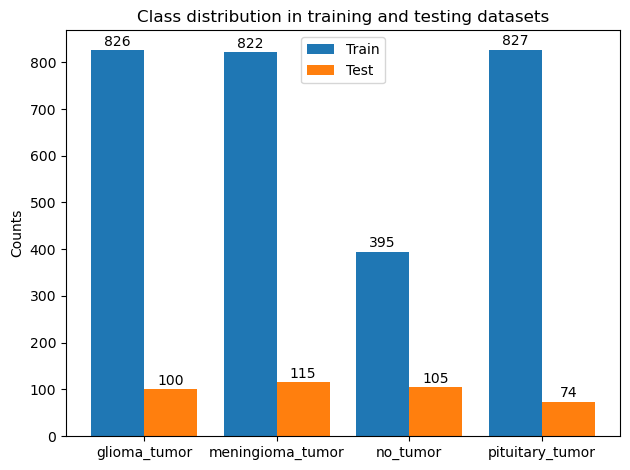

In [9]:
visualize_class_distribution(y_train, y_test)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [11]:
# Preprocess labels: convert to one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [13]:
base_model01 = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=shape)

for layer in base_model01.layers:
    layer.trainable = False

In [14]:
x01 = base_model01.output
x01 = GlobalMaxPooling2D()(x01)
x01 = Dense(1024, activation="relu")(x01)
predictions = Dense(4, activation="softmax")(x01)

In [15]:
model01 = Model(inputs=base_model01.input, outputs=predictions)

In [16]:
model01.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
history01 = model01.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.5047 - loss: 18.6974 - val_accuracy: 0.8415 - val_loss: 0.4632
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8662 - loss: 0.3761 - val_accuracy: 0.7195 - val_loss: 0.8611
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8782 - loss: 0.3135 - val_accuracy: 0.8780 - val_loss: 0.3340
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9347 - loss: 0.1643 - val_accuracy: 0.8833 - val_loss: 0.3705
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9367 - loss: 0.1495 - val_accuracy: 0.8833 - val_loss: 0.3658
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9713 - loss: 0.0847 - val_accuracy: 0.8902 - val_loss: 0.3591
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9284 - loss: 0.2004 - val_accuracy: 0.8328 - val_loss: 0.6015
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9512 - loss: 0.1213 - val_accuracy: 0.8937 - 

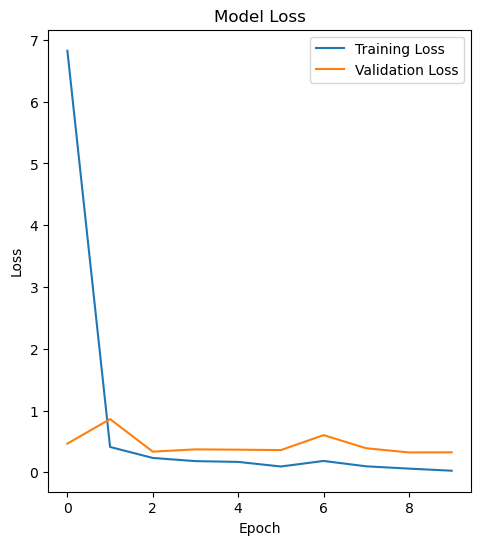

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history01.history["loss"], label="Training Loss")
plt.plot(history01.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

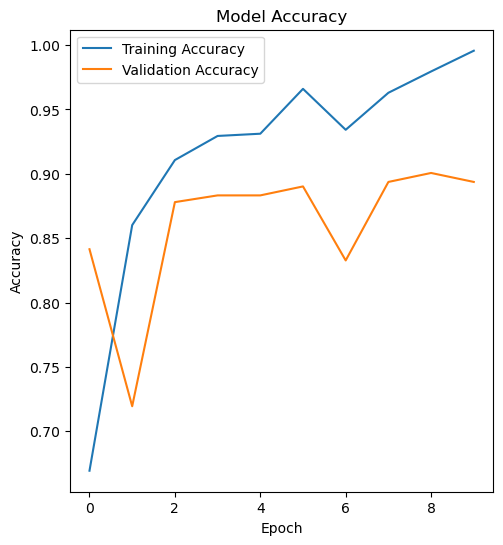

In [42]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history01.history["accuracy"], label="Training Accuracy")
plt.plot(history01.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [20]:
test_loss, test_acc = model01.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5867 - loss: 2.7455
Test accuracy: 0.789340078830719
Test loss: 1.4119188785552979


In [21]:
y_pred_probs = model01.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


In [22]:
conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [23]:
print(f"Confusion Matrix:\n{conf_matrix}")

print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Confusion Matrix:
[[ 30  45  24   1]
 [  3 108   4   0]
 [  0   0 105   0]
 [  0   6   0  68]]
Accuracy: 0.7893401015228426
Precision: 0.8244786079447971
Recall: 0.7893401015228426
F1 Score: 0.7583614148797166


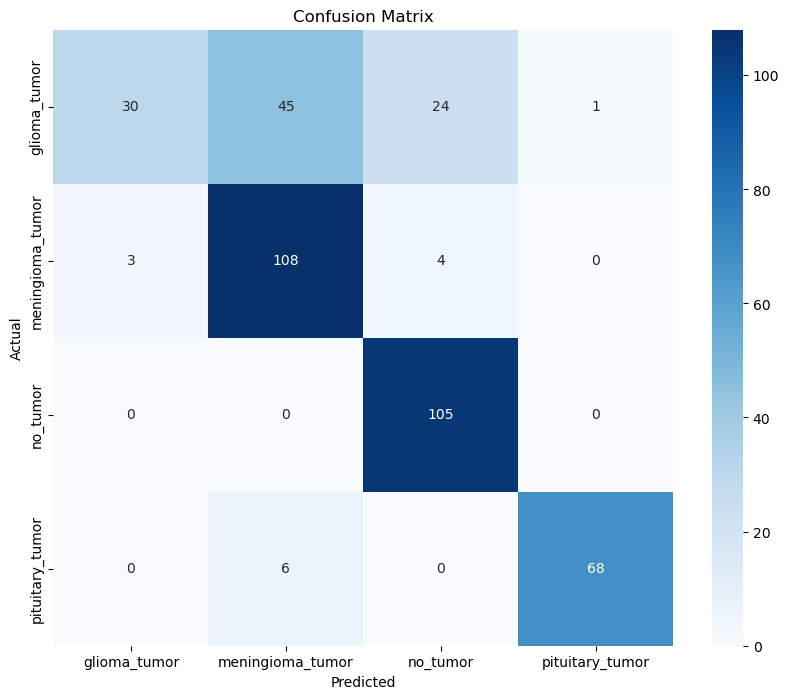

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "ResNet50_01.h5")
model01.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\ResNet50_01.h5


In [26]:
base_model02 = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=shape)

for layer in base_model02.layers:
    layer.trainable = False

In [27]:
x02 = base_model02.output
x02 = GlobalMaxPooling2D()(x02)
x02 = Dense(1024)(x02)
x02 = BatchNormalization()(x02)
x02 = Activation("relu")(x02)
x02 = Dropout(0.5)(x02)

x02 = Dense(512)(x02)
x02 = BatchNormalization()(x02)
x02 = Activation("relu")(x02)
x02 = Dropout(0.5)(x02)

predictions = Dense(4, activation="softmax")(x02)

In [28]:
model02 = Model(inputs=base_model02.input, outputs=predictions)

In [29]:
model02.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [30]:
history02 = model02.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6526 - loss: 0.9485 - val_accuracy: 0.6376 - val_loss: 1.8077
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8665 - loss: 0.3449 - val_accuracy: 0.8519 - val_loss: 0.4162
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9301 - loss: 0.2118 - val_accuracy: 0.8920 - val_loss: 0.3479
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9487 - loss: 0.1386 - val_accuracy: 0.8937 - val_loss: 0.2814
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9591 - loss: 0.1165 - val_accuracy: 0.9042 - val_loss: 0.3212
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9691 - loss: 0.0874 - val_accuracy: 0.8659 - val_loss: 0.5295
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9615 - loss: 0.1103 - val_accuracy: 0.8990 - val_loss: 0.3409
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9764 - loss: 0.0677 - val_accuracy: 0.9042 - v

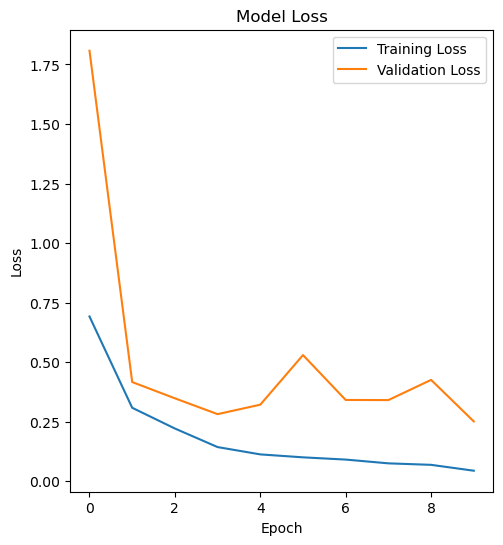

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history02.history["loss"], label="Training Loss")
plt.plot(history02.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

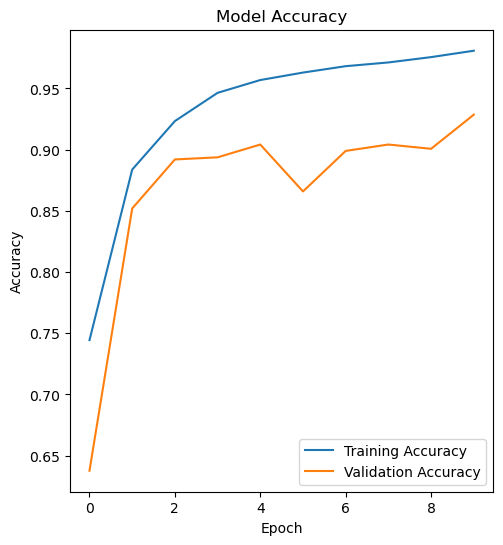

In [39]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history02.history["accuracy"], label="Training Accuracy")
plt.plot(history02.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [33]:
test_loss, test_acc = model02.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5677 - loss: 3.4743
Test accuracy: 0.7817258834838867
Test loss: 1.7051845788955688


In [34]:
y_pred_probs = model02.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


In [35]:
conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [36]:
print(f"Confusion Matrix:\n{conf_matrix}")

print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Confusion Matrix:
[[ 25  57  16   2]
 [  0 113   2   0]
 [  0   1 104   0]
 [  0   6   2  66]]
Accuracy: 0.7817258883248731
Precision: 0.8459546310579751
Recall: 0.7817258883248731
F1 Score: 0.7440780729663351


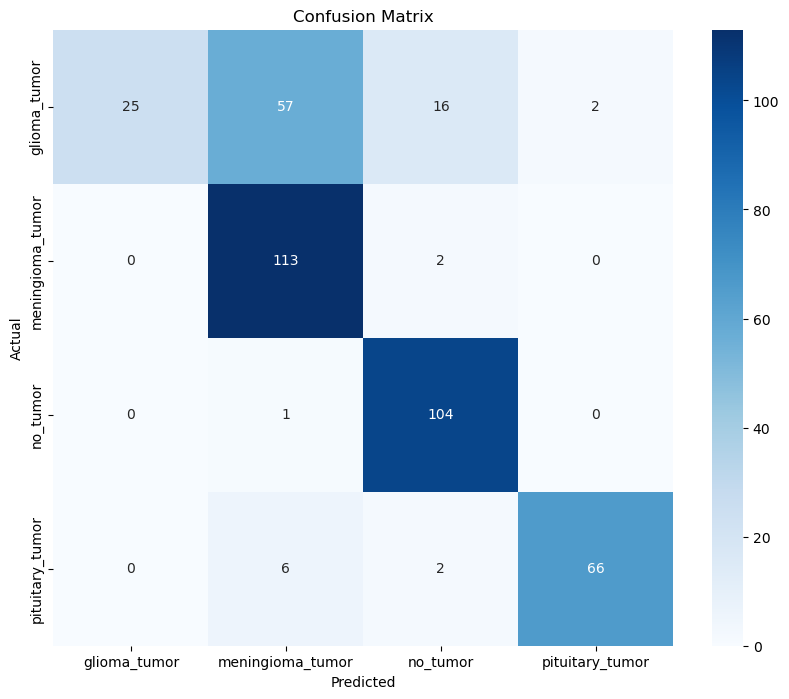

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [38]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "ResNet50_02.h5")
model02.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\ResNet50_02.h5
